In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os

import geopandas as gpd
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lib import merge_in_geometry
from plot import map_outage

/tmp/ipykernel_4140768/3416802526.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
def state_FIPS_from_alpha_2(alpha_2_codes: list[str], states: pd.DataFrame) -> dict[str, int]:
    """
    Lookup list of US state FIPS codes given a list of two letter codes.
    
    Args:
        alpha_2_codes: List of state codes, e.g. ["NC", "SC"]
    
    Returns:
        Mapping from argument code to FIPS integer code, e.g. {'NC': 37, 'SC': 45}
    """
    state_codes = map(str.upper, alpha_2_codes)
    return dict(states.set_index("state_alpha_2_code").loc[state_codes].state_fips_code)

In [4]:
plt.style.use('dark_background')  # for cool points

root_dir = "data"

# temporal window we're interested in plotting
year = 2018

start = f"{year}-09-13"
stop = f"{year}-09-29"

# read in US county boundaries from shapefile
county_boundaries: gpd.GeoDataFrame = gpd.read_file(os.path.join(root_dir, "raw/counties/cb_2018_us_county_500k.shp"))
states: pd.DataFrame = pd.read_csv(os.path.join(root_dir, "raw/states/state_codes.csv"))
processed_path = os.path.join(root_dir, f"processed/outage/{year}.parquet")
data = pd.read_parquet(processed_path)

outage: gpd.GeoDataFrame = merge_in_geometry(data[start: stop], county_boundaries)

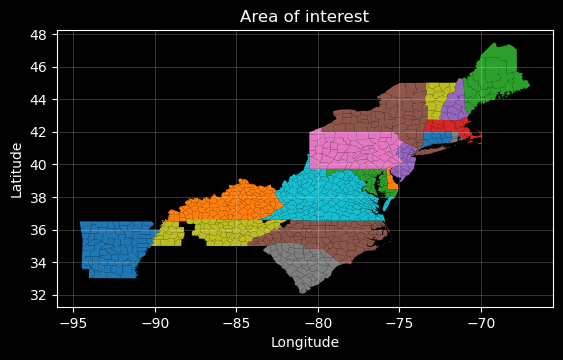

In [5]:
state_alpha_2_codes = [
    "AR",
    "NC",
    "SC",
    "TN",
    "KY",
    "VA",
    "WV",
    "PA",
    "MD",
    "DE",
    "NJ",
    "NY",
    "CT",
    "RI",
    "MA",
    "NH",
    "VT",
    "ME"
]
# codes are strings in `outage` to preserve leading zeros, we must zero pad and cast to str to match
state_FIPS_codes = [f"{code:02d}" for code in state_FIPS_from_alpha_2(state_alpha_2_codes, states).values()]

# filter geographically
outage_AOI = outage[outage.STATEFP.isin(state_FIPS_codes)]

# counties we're analysing
ax = outage_AOI.groupby(outage_AOI.CountyFIPS).first().plot(column="STATEFP")
ax.set_title("Area of interest")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(alpha=0.2)

In [6]:
# animate Irma electricity outage
map_outage(
    outage_AOI,
    "east_coast_florence_2018",
    60,
    "Hurricane Florence 2018: power outages by US county",
    "plots",
)

Making frames with n_cpu=60...
Animating into .gif with imagemagick...
Done
